In [1]:
# Constants used in the program:

# NODAL_SIZE_DATA_FOLDER is where all the data from size-analysis is saved. This refers to the nodal analysis.
NODAL_SIZE_DATA_FOLDER = "../../summer_size_analysis_10092020/"

# BRANCH_DATA_FOLDER is where all the data from branch-analysis is saved.
BRANCH_DATA_FOLDER = "../../summer_size_analysis_11242020/"
BRANCH_DATA_FOLDER = "../../summer_size_analysis_01052021/"

# CDF_FILE_OUTPUT is where the CDF graph will be outputted to
CDF_FILE_OUTPUT = 'CDF_final_01052021.pdf'

In [2]:
import json 
import os

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
# dictionary to keep track of the node size analysis data
old_all_websites = {}

# gets data from node size analysis
for root, dirs, files in os.walk(NODAL_SIZE_DATA_FOLDER, topdown=False):
    for name in files:

        # obtains all the websites' info for calculating ratios
        if 'resource_ratio' in name:
            filePath = os.path.join(root, name)
            f = open(filePath, 'r')
            resource_ratio = json.loads(f.read())
            for x in resource_ratio:
                old_all_websites[x] = {}
                old_all_websites[x]["total_blocked_size"] = resource_ratio[x]['total_blocked_bytes']
                old_all_websites[x]["total_size"] = resource_ratio[x]['total_bytes']
                old_all_websites[x]["ratio"] = resource_ratio[x]['ratio']

In [5]:
# From branch-analysis.py's output:
# tracker, ad, unknown, total blocked, total_unblocked_with_blocked_ancestor , remaining blocked (not visited), unblocked
final_all_websites = {}
count = 0
for root, dirs, files in os.walk(BRANCH_DATA_FOLDER, topdown=False):
    for name in files:
        # goes through the data generated from the branch-analysis script
        if('size_analysis' in name):
            filePath = os.path.join(root, name)
            with open(filePath, 'r') as f:
                lines = f.read().splitlines()
                
                # For each website:
                for line in lines:
                    fields = line.split(',')
                    url = fields[0] # URL of the website
                    tracker_and_ad_bytes = int(fields[1]) # number of bytes attributed to blocked tracker_and_ad_bytes branches
                    tracker_bytes = int(fields[2]) # number of bytes attributed to blocked tracker branches
                    ad_bytes = int(fields[3]) # number of bytes attributed to blocked ad branches
                    unknown_bytes = int(fields[4]) # number of bytes attributed to unknown blocked branches
                    total_blocked_bytes = int(fields[5])   # tracker + ad + unknown = total bytes from blocked branches
                    total_unblocked_with_blocked_ancestor = int(fields[6]) # unblocked resources but with blocked ancestors
                    remaining_blocked_not_visited = int(fields[7]) # any blocked that are not visited (maybe no initiator)
                    unblocked_bytes = int(fields[8]) # any unblocked_bytes that are in unblocked branches.

                    # total blocked bytes = total_blocked_bytes + remaining_blocked_not_visited
                    final_all_websites[url] = {}
                    final_all_websites[url]["total_blocked_size"] = int(total_blocked_bytes) + int(remaining_blocked_not_visited)
                    final_all_websites[url]["total_size"] = old_all_websites[url]["total_size"]
                    final_all_websites[url]["tracker_and_ad_bytes"] = tracker_and_ad_bytes
                    final_all_websites[url]["tracker_bytes"] = tracker_bytes
                    final_all_websites[url]["ad_bytes"] = ad_bytes
                    final_all_websites[url]["unknown_bytes"] =unknown_bytes 
                    if unknown_bytes > 0:
                        count+=1
                    final_all_websites[url]["total_blocked_bytes"] = total_blocked_bytes
                    final_all_websites[url]["total_unblocked_with_blocked_ancestor"] = total_unblocked_with_blocked_ancestor
                    final_all_websites[url]["remaining_blocked_not_visited"] = remaining_blocked_not_visited
                    final_all_websites[url]["unblocked_bytes"] = unblocked_bytes
                    # calculate the ratio of blocked sizes
                    # We use the old node analysis data because it gives us the max size of resources in a website.
                    try:
                        final_all_websites[url]["ratio"] = float(final_all_websites[url]["total_blocked_size"]) / old_all_websites[url]["total_size"]
                        if(final_all_websites[url]["ratio"] < 0):
                            final_all_websites[url]["ratio"] = 0
                    except ValueError as err:
                        print(err)
                    except ZeroDivisionError as err:
                        final_all_websites[url]["ratio"] = 0

        
        if('branch_info' in name):
            filePath = os.path.join(root, name)
            with open(filePath, 'r') as f:
                lines = f.read().splitlines()
                
                # For each website:
                for line in lines:
                    fields = line.split(',')
                    url = fields[0] # URL of the website
                    num_tracker_and_ads_branches = int(fields[1])
                    num_tracker_branches = int(fields[2])
                    num_ad_branches = int(fields[3])
                    num_unknown_branches = int(fields[4])
                    num_unblocked_branches = int(fields[5])

                    # total blocked bytes = total_blocked_bytes + remaining_blocked_not_visited
                    final_all_websites[url] = {}
                    final_all_websites[url]["num_tracker_and_ads_branches"] = num_tracker_and_ads_branches
                    final_all_websites[url]["num_tracker_branches"] = num_tracker_branches
                    final_all_websites[url]["num_ad_branches"] =num_ad_branches 
                    final_all_websites[url]["num_unknown_branches"] = num_unknown_branches
                    final_all_websites[url]["num_unblocked_branches"] = num_unblocked_branches
                    

In [6]:
print(count)

211714


In [7]:
# Calculate the STD+MED+MEAN of total sizes and total blocked sizes by putting all the data in lists:
final_list_all_total_blocked_size = []
final_list_all_total_size = []
final_list_all_ratios = []
final_dictionary_all_total_blocked_size = {}
final_dictionary_all_total_size = {}
final_dictionary_all_ratios = {}

for website in final_all_websites:
    final_list_all_total_blocked_size.append(final_all_websites[website]["total_blocked_size"])
    final_list_all_total_size.append(final_all_websites[website]["total_size"])
    final_list_all_ratios.append(final_all_websites[website]["ratio"])
    final_dictionary_all_total_blocked_size[website] = final_all_websites[website]["total_blocked_size"]
    final_dictionary_all_total_size[website] = final_all_websites[website]["total_size"]
    final_dictionary_all_ratios[website] = final_all_websites[website]["ratio"]

In [8]:
import statistics as stats
# STDEV MEAN MEDIAN
print("---------------------------------------------------------")
print("-----------------Blocked---------------------------------")
print("Population STDEV: ", stats.pstdev(final_list_all_total_blocked_size) / 1000000, "MB")
print("Standard STDEV: ", stats.stdev(final_list_all_total_blocked_size) / 1000000, "MB")
print("MEAN: ", stats.mean(final_list_all_total_blocked_size) / 1000000, "MB")
print("MEDIAN: ", stats.median(final_list_all_total_blocked_size) / 1000000, "MB")


print("---------------------------------------------------------")
print("---------------Total Sizes--------------------------------")



print("Population STDEV: ", stats.pstdev(final_list_all_total_size) / 1000000, "MB")
print("Standard STDEV: ", stats.stdev(final_list_all_total_size) / 1000000, "MB")
print("MEAN: ", stats.mean(final_list_all_total_size) / 1000000, "MB")
print("MEDIAN: ", stats.median(final_list_all_total_size) / 1000000, "MB")



print("---------------------------------------------------------")
print("---------------------------------------------------------")

---------------------------------------------------------
-----------------Blocked---------------------------------
Population STDEV:  0.6968200640871848 MB
Standard STDEV:  0.696820577183589 MB
MEAN:  0.18780975398469887 MB
MEDIAN:  0.055139 MB
---------------------------------------------------------
---------------Total Sizes--------------------------------
Population STDEV:  8.690695732047143 MB
Standard STDEV:  8.690702131353019 MB
MEAN:  3.5472382975590357 MB
MEDIAN:  1.651595 MB
---------------------------------------------------------
---------------------------------------------------------


In [9]:
# buckets for ratios and sizes

high_size_websites = []
mid_size_websites = []
low_size_websites = []
high_ratio_websites = []
mid_ratio_websites = []
low_ratio_websites = []

# Goes through each website and categorizes them based on their degree of blocked ratio/blocked sizes
for website in final_all_websites:
    if final_all_websites[website]["total_blocked_size"] > 1000000:
        high_size_websites.append(website)
    elif final_all_websites[website]["total_blocked_size"] <= 1000000 and final_all_websites[website]["total_blocked_size"] >= 1000:
        mid_size_websites.append(website)
    else:
        low_size_websites.append(website)
    if final_all_websites[website]["ratio"] > 0.8:
        high_ratio_websites.append(website)
    elif final_all_websites[website]["ratio"] >= 0.3 and final_all_websites[website]["ratio"] <= 0.8 :
        mid_ratio_websites.append(website)
    else:
        low_ratio_websites.append(website)
        
print("High Size: \t", len(high_size_websites))
print("Mid Size: \t", len(mid_size_websites))
print("Low Size: \t", len(low_size_websites))
print("High Ratio: \t", len(high_ratio_websites))
print("Mid Ratio: \t", len(mid_ratio_websites))
print("Low Ratio: \t", len(low_ratio_websites))

High Size: 	 18490
Mid Size: 	 495694
Low Size: 	 164851
High Ratio: 	 12505
Mid Ratio: 	 73214
Low Ratio: 	 593316


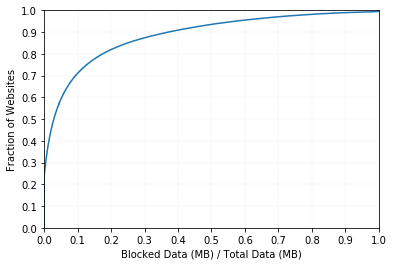

In [10]:
# from matplotlib import rcParams
fig, ax = plt.subplots()

# Makes the font sanserif and sets the size to 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


# plot the cumulative histogram using 1 million buckets
n, bins, patches = ax.hist(final_list_all_ratios, 1000000, density=True, histtype='step',
                           cumulative=True, label='Empirical', linewidth=1.5)

# This statement removes the very last data point to remove a vertical line at the end for consistency among graphs
patches[0].set_xy(patches[0].get_xy()[:-1])
plt.ylabel("Fraction of Websites")
plt.xlabel("Blocked Data (MB) / Total Data (MB)")

# sets the ticks on the axes
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# limits the domain and range of graph to [0,1]
plt.xlim([0,1.0])
plt.ylim([0,1.0])

# adds a gray grid for readability
ax.set_axisbelow(True)
plt.grid(color='#888888', linestyle=':', linewidth=0.1)

plt.savefig(CDF_FILE_OUTPUT, format='pdf')
plt.show()

In [11]:
# shows percent of websites that has at most no blocked ratio, 1% blocked ratio, and 10% blocked ratio
print("% of Websites with 0 blocked:", n[0]) # < 0%
print("% of Websites with < 0.01 ratio:", n[10000]) # < 1% ratio
print("% of Websites with < 0.1 ratio:", n[100000]) # < 10%

% of Websites with 0 blocked: 0.21954832961482104
% of Websites with < 0.01 ratio: 0.3590772198782534
% of Websites with < 0.1 ratio: 0.7102270133363062


In [12]:
# Sorts the websites by total blocked size
final_sort_websites_size = sorted(final_dictionary_all_total_blocked_size.items(), key=lambda x : x[1], reverse = True)

# prints the top 10 blocked sites and their respective size and ratios
# print(final_sort_websites_size[:10]) # Total block sizes
print("website & size in MB & ratio")
print("----------------------------")
for x in final_sort_websites_size[:10]:
    print(x[0], '&',str(x[1] / 1000000)[0:4], '&', str(final_dictionary_all_ratios[x[0]])[0:5])

website & size in MB & ratio
----------------------------
harddrivebenchmark.net & 117. & 0.995
utm.edu.ec & 97.3 & 0.999
ilovesupersport.com & 87.0 & 0.978
portalsosnowiec.pl & 72.6 & 0.969
riverheadlocal.com & 72.1 & 0.933
bitsbox.com & 70.8 & 0.988
xomad.com & 68.6 & 0.956
free-blogger-tamplat.blogspot.com & 64.5 & 0.682
royalenfield.com & 58.6 & 0.958
signshop.co.il & 58.6 & 0.949


In [13]:
# sanity check that nodal size analysis contain the same # of websites as the branch size analysis
assert(set(old_all_websites.keys()) - set(final_all_websites.keys()) == set())

In [14]:
# From branch-analysis.py's output:
# tracker, ad, unknown, total blocked, total_unblocked_with_blocked_ancestor , remaining blocked (not visited), unblocked
for root, dirs, files in os.walk(BRANCH_DATA_FOLDER, topdown=False):
    for name in files:
        # goes through the data generated from the branch-analysis script
        if('remaining' in name):
            filePath = os.path.join(root, name)
            with open(filePath, 'r') as f:
                lines = f.read().splitlines()
                
                # For each website:
                for line in lines:
                    fields = line.split(',')
                    url = fields[0] # URL of the website
                    remaining_tracker_and_ad_bytes = int(fields[1]) # number of bytes attributed to blocked tracker_and_ad_bytes branches
                    remaining_tracker_bytes = int(fields[2]) # number of bytes attributed to blocked tracker branches
                    remaining_ad_bytes = int(fields[3]) # number of bytes attributed to blocked ad branches
                    remaining_unknown_bytes = int(fields[4]) # number of bytes attributed to unknown blocked branches

                    remaining_bytes = remaining_tracker_and_ad_bytes + remaining_tracker_bytes +  remaining_ad_bytes + remaining_unknown_bytes
                    if not remaining_bytes == final_all_websites[url]["remaining_blocked_not_visited"]:
                        print("bad")